In [1]:
import sys
sys.path.append("..")

import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from reader import generic_reader

In [2]:
df_movies = generic_reader.read_csv_file_to_data_frame("movie_data/movies_clean.csv")
df_persons = generic_reader.read_csv_file_to_data_frame("movie_data/persons_clean.csv")

Creating a new column with the main lead of the movie the index[0] of cast_person_ids and dropping cast_person_ids column

In [3]:
df_movies['cast_person_ids'] = df_movies['cast_person_ids'].apply(ast.literal_eval)

df_movies['cast_person_id'] = df_movies['cast_person_ids'].str[0].astype('Int64')

df_movies = df_movies.drop(columns=['cast_person_ids'])

print(df_movies[['cast_person_id']].head())

   cast_person_id
0           98740
1             109
2          170638
3          224817
4         1839942


In [4]:
df_merged = df_movies.merge(
    df_persons,
    left_on="cast_person_id",
    right_on="person_id",
    how="left",
    suffixes=("", "_cast")
)

# Show result
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20489 entries, 0 to 20488
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   budget               20489 non-null  int64  
 1   movie_id             20489 non-null  int64  
 2   original_title       20489 non-null  object 
 3   overview             20481 non-null  object 
 4   release_date         20489 non-null  object 
 5   revenue              20489 non-null  int64  
 6   runtime              20489 non-null  int64  
 7   vote_average         20489 non-null  float64
 8   vote_count           20489 non-null  int64  
 9   director_person_ids  20489 non-null  object 
 10  genre_ids            20489 non-null  object 
 11  collection_id        2401 non-null   float64
 12  cast_credit_ids      20489 non-null  object 
 13  crew_person_ids      20489 non-null  object 
 14  crew_credit_ids      20489 non-null  object 
 15  budget_2023_usd      20489 non-null 

Removing actors/actress greater than 100 due to the assumetion that the deathday data is missing

In [ ]:
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'])
df_merged['birthday'] = pd.to_datetime(df_merged['birthday'])

df_merged['age_at_release'] = df_merged.apply(
    lambda row: row['release_date'].year - row['birthday'].year - 
                ((row['release_date'].month, row['release_date'].day) < (row['birthday'].month, row['birthday'].day)),
    axis=1
)

df_merged = df_merged[df_merged['age_at_release'].notna() & (df_merged['age_at_release'] <= 100)]

df_merged[['original_title', 'release_date', 'birthday', 'age_at_release']].head()


,original_title,release_date,birthday,age_at_release
0,Carnage: The Legend of Quiltface,2000-01-01,NaT,NaN
1,The Bumblebee Flies Anyway,2000-01-01,1981-01-28,18.0
2,After Sex,2000-01-01,1967-09-14,32.0
3,The Mummy Theme Park,2000-01-01,NaT,NaN
4,The Complete Works of William Shakespeare (Abr...,2000-01-01,NaT,NaN


In [ ]:
df_merged['budget'].describe()
df_merged['budget_2023_usd'].describe()

count    1.761400e+04
mean     1.249013e+07
std      3.702812e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.538927e+06
max      6.079353e+08
Name: budget_2023_usd, dtype: float64

[]


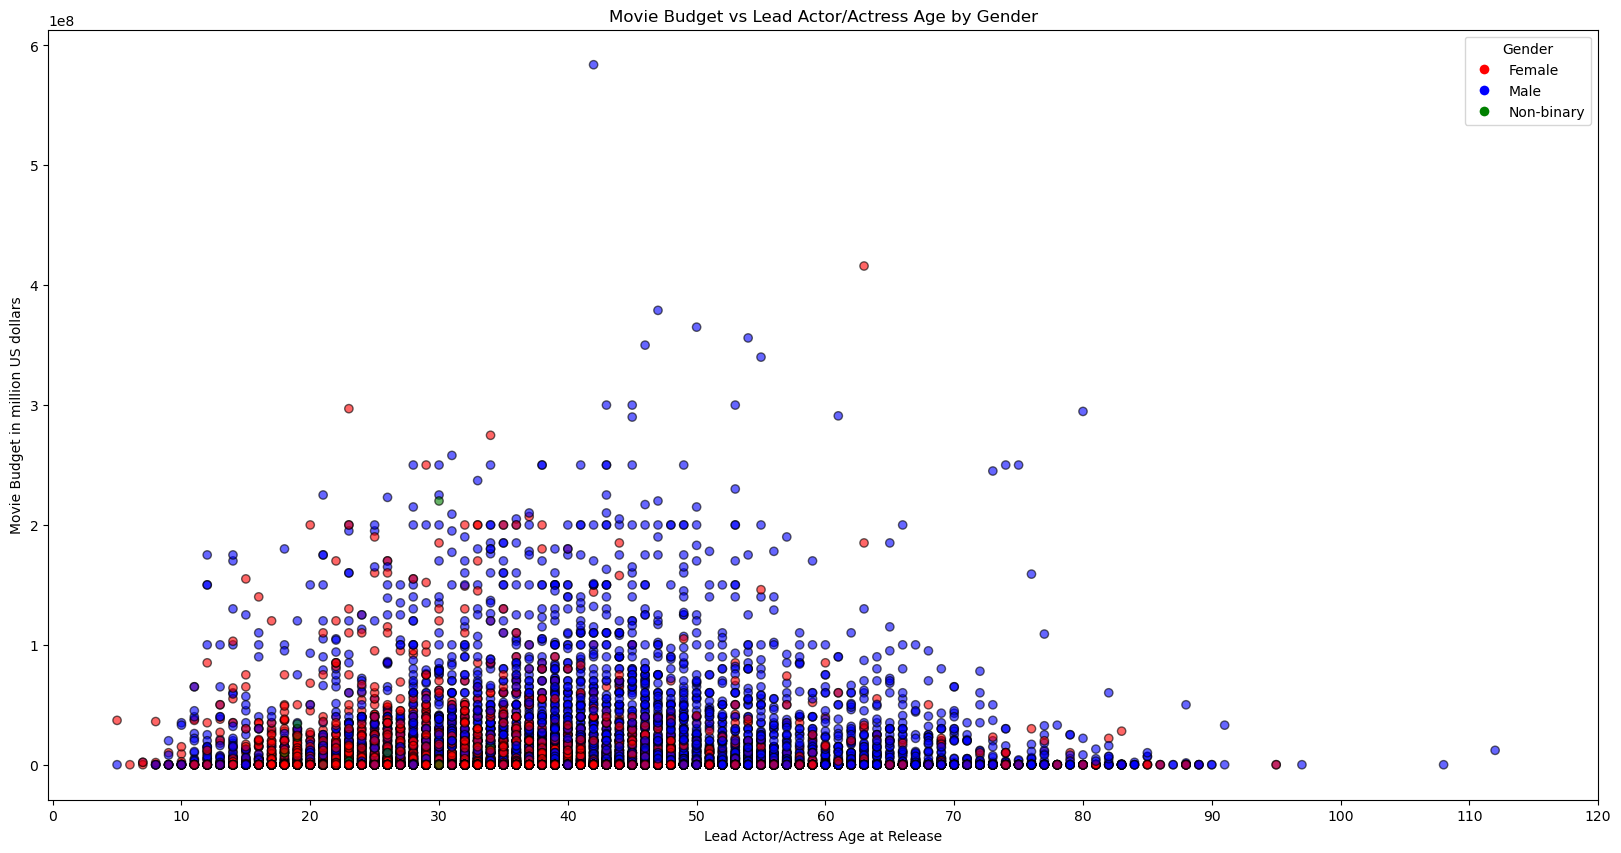

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df_merged = df_merged[df_merged['gender'].isin([1, 2, 3])]

# Ensure gender is integer
df_merged['gender_filled'] = df_merged['gender'].astype(int)

gender_colors = {
    1: 'red',     # female
    2: 'blue',    # male
    3: 'green'    # non-binary
}
df_merged['color'] = df_merged['gender_filled'].map(gender_colors).fillna('gray')

print(df_merged.loc[df_merged['color'].isna(), 'gender_filled'].unique())

plt.figure(figsize=(20, 10))
plt.scatter(
    df_merged['age_at_release'],
    df_merged['budget'],
    c=df_merged['color'],
    alpha=0.6,
    edgecolor='k'
)

plt.xlabel("Lead Actor/Actress Age at Release")
plt.ylabel("Movie Budget in million US dollars")
plt.title("Movie Budget vs Lead Actor/Actress Age by Gender")

# Set x-axis steps
plt.xticks(range(0, int(df_merged['age_at_release'].max()) + 10, 10))

# Infobox
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-binary', markerfacecolor='green', markersize=8)
]
plt.legend(handles=legend_elements, title="Gender")

plt.show()


In [8]:
#Test med en profit column
df_merged['profit'] = df_merged['revenue'] - df_merged['budget']

In [9]:
gender_labels = {1: "Female", 2: "Male", 3: "Non-binary"}

df_merged['gender_label'] = df_merged['gender_filled'].astype(int).map(gender_labels)

df_merged.to_csv("movie_data/to_streamlit.csv", index=False)

In [10]:
df_merged['gender_filled'].map(gender_labels).value_counts()

gender_filled
Male          10121
Female         7418
Non-binary       75
Name: count, dtype: int64